# Investigating GW x Galaxy cross-correlations

In this notebook, we will attempt to reproduce the results obtained in [this paper](https://arxiv.org/abs/1603.02356).

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from src.camb_interface import CAMBInterface
from src.cosmology import Cosmology
from src.density import *
from src.kernel import *
from src.tracer import *
from src.power import Power

We fix the fiducial cosmology with parameters from Planck 2018. We compute the matter power spectrum with `CAMB`:

Note: redshifts have been re-sorted (earliest first)


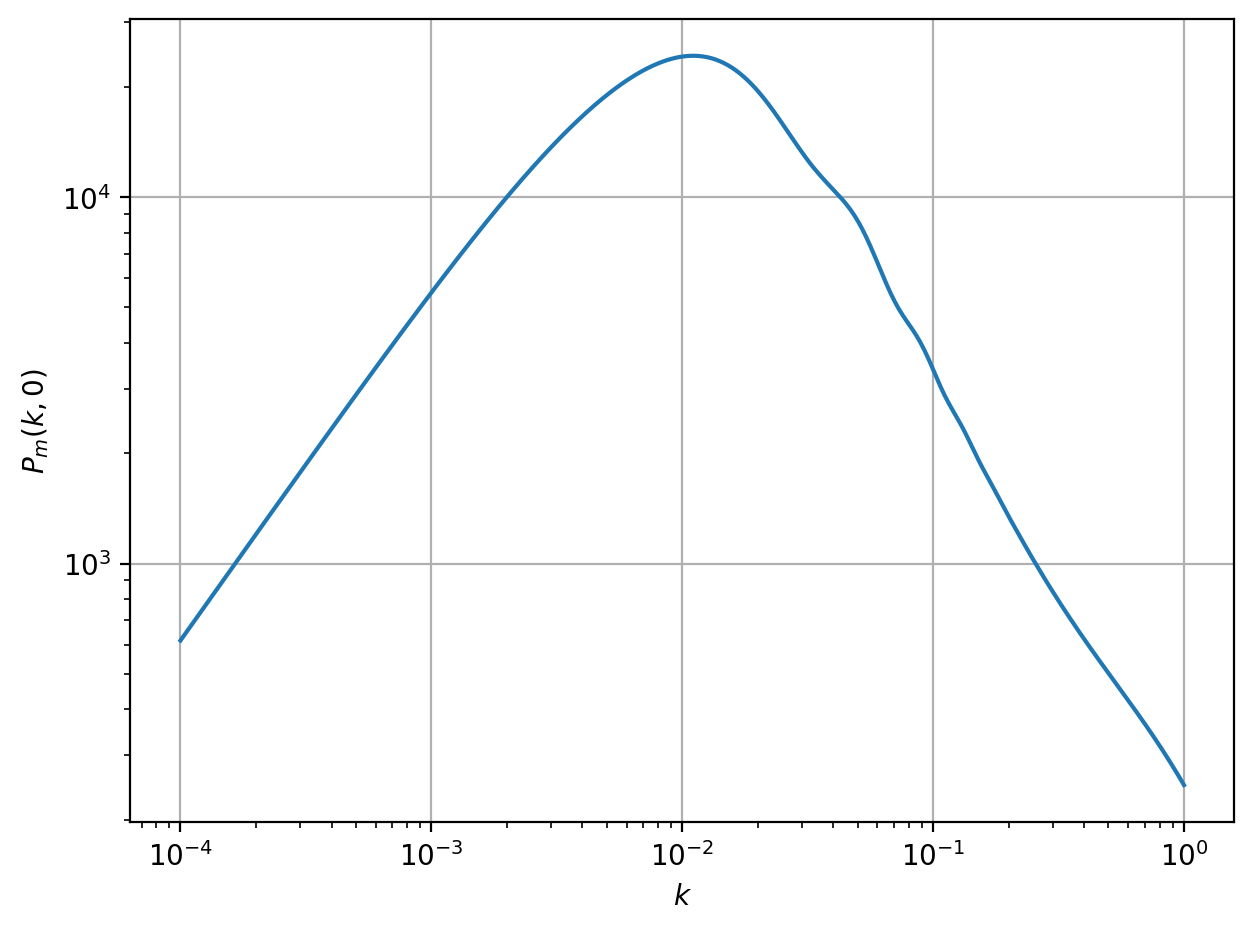

In [2]:
zmin = 1e-4
zmax = 1.5
npoints = 500
z = np.linspace(zmin, zmax, npoints)
k = np.logspace(-4, 0, npoints)
camb_interface = CAMBInterface(zmin, zmax)
camb_interface.run_solver()
cosmology = Cosmology(camb_interface)
pm = cosmology.matter_power_spectrum_interpolator().P

fig, ax = plt.subplots()
ax.plot(k, pm(0, k))
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P_m(k, 0)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
fig.tight_layout()
plt.show()

Defining the redshift bins:

In [3]:
def galaxy_bin(zg, delta_z):
    return RadialBin(zg - 0.5 * delta_z, zg + 0.5 * delta_z)

nbins = 20
zg_arr = np.linspace(zmin + 0.05, 1.3, nbins)
g_bins = [galaxy_bin(zg, 0.1) for zg in zg_arr]
gw_bin = RadialBin(0.9, 1.1)

Defining both tracers:

In [4]:
g_density = UniformInVolumeNumberDensity(1e-3, cosmology)
gw_density = UniformInVolumeNumberDensity(3e-6, cosmology)

g_kernels = [ClusteringKernel('galaxy clustering', 'g')]
gw_kernels = [
    ClusteringKernel('gw clustering', 's'),
    WeakLensingKernel('gw lensing', 't')
    ]

g_window_functions = [BoxWindowFunction()]
gw_window_functions = [
    GWClusteringWindowFunction(cosmology, 0.05),
    GWLensingWindowFunction(cosmology, 0.05)
    ]

g_bias = GrowthRateBias(cosmology)
gw_bias = GrowthRateBias(cosmology)

g_tracer = Tracer(g_density, g_kernels, g_window_functions, g_bias)
gw_tracer = Tracer(gw_density, gw_kernels, gw_window_functions, gw_bias)

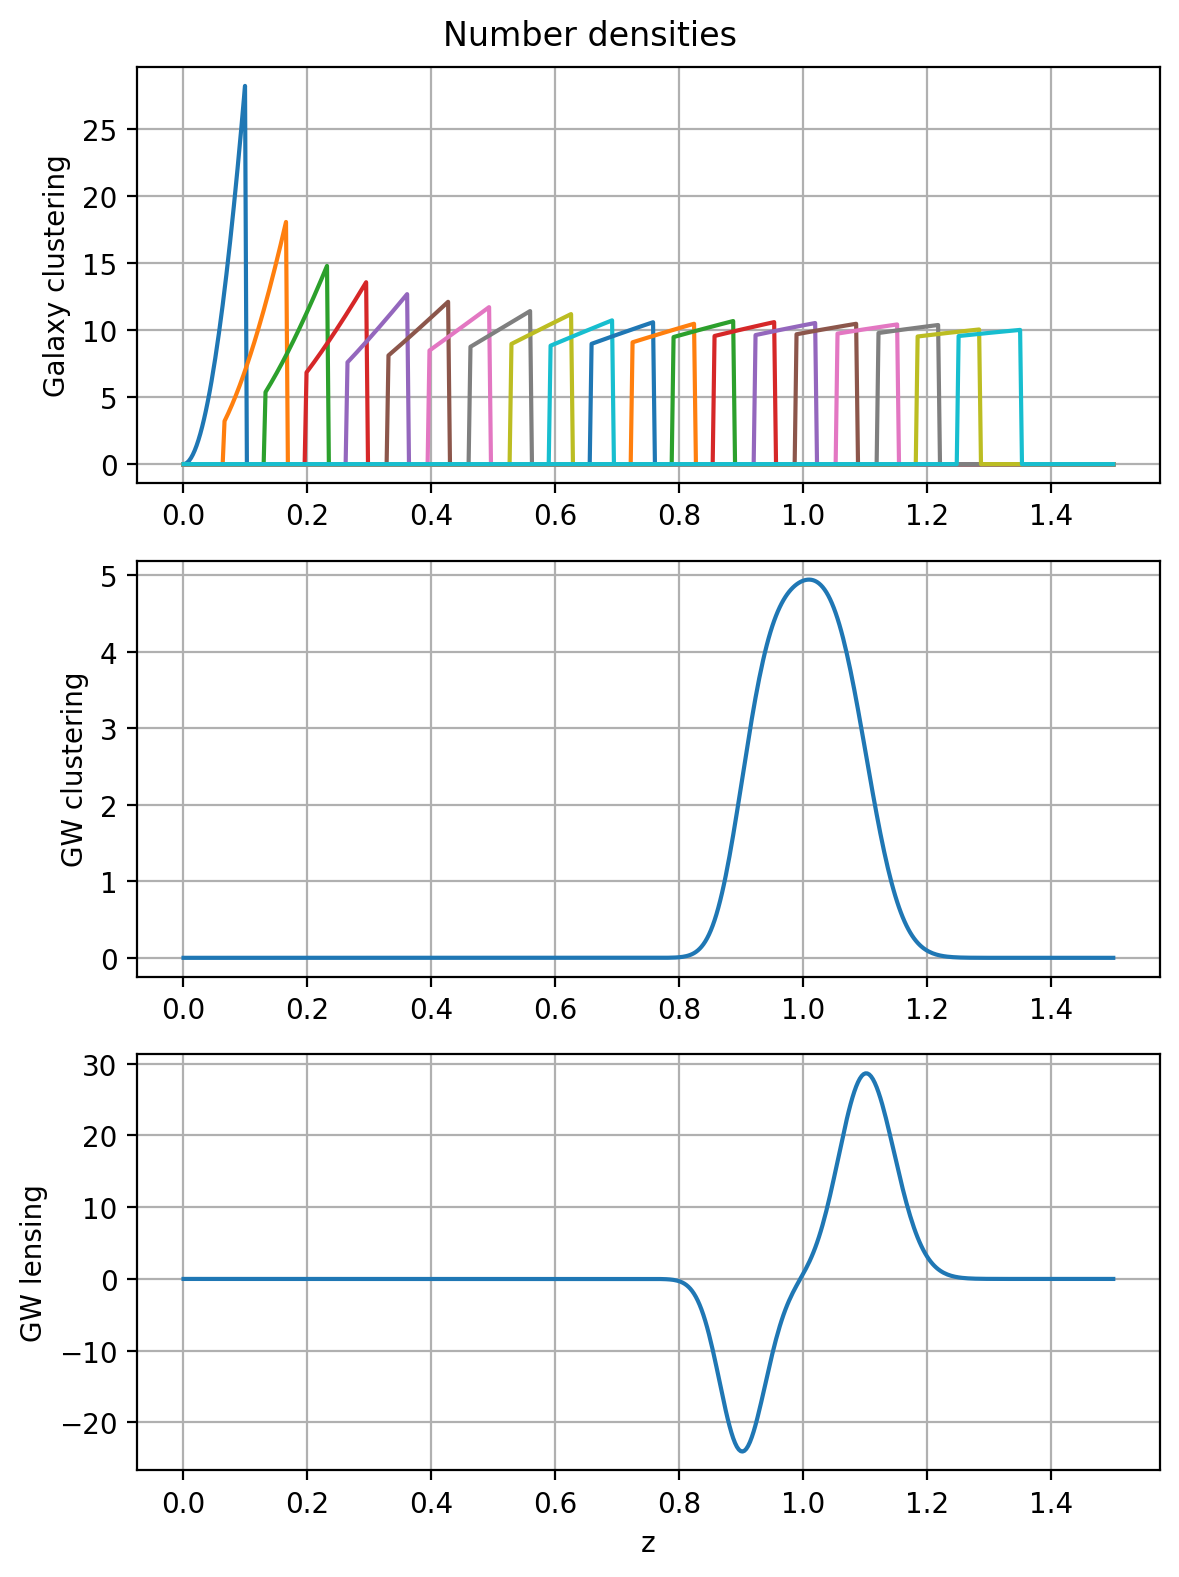

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
for i, zbin in enumerate(g_bins):
    ng = g_tracer.normalized_density(zbin, z, 'galaxy clustering')

    
    ax1.plot(z, ng, label=f'Bin {i + 1}')

ns = gw_tracer.normalized_density(gw_bin, z, 'gw clustering')
nt = gw_tracer.normalized_density(gw_bin, z, 'gw lensing')
ax2.plot(z, ns)
ax3.plot(z, nt)

ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_ylabel('Galaxy clustering')
ax2.set_ylabel('GW clustering')
ax3.set_ylabel('GW lensing')
#ax1.legend()
ax3.set_xlabel('z')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Number densities')
plt.show()

Computing the galaxy and GW kernels that enter the $C_\ell$ computation:

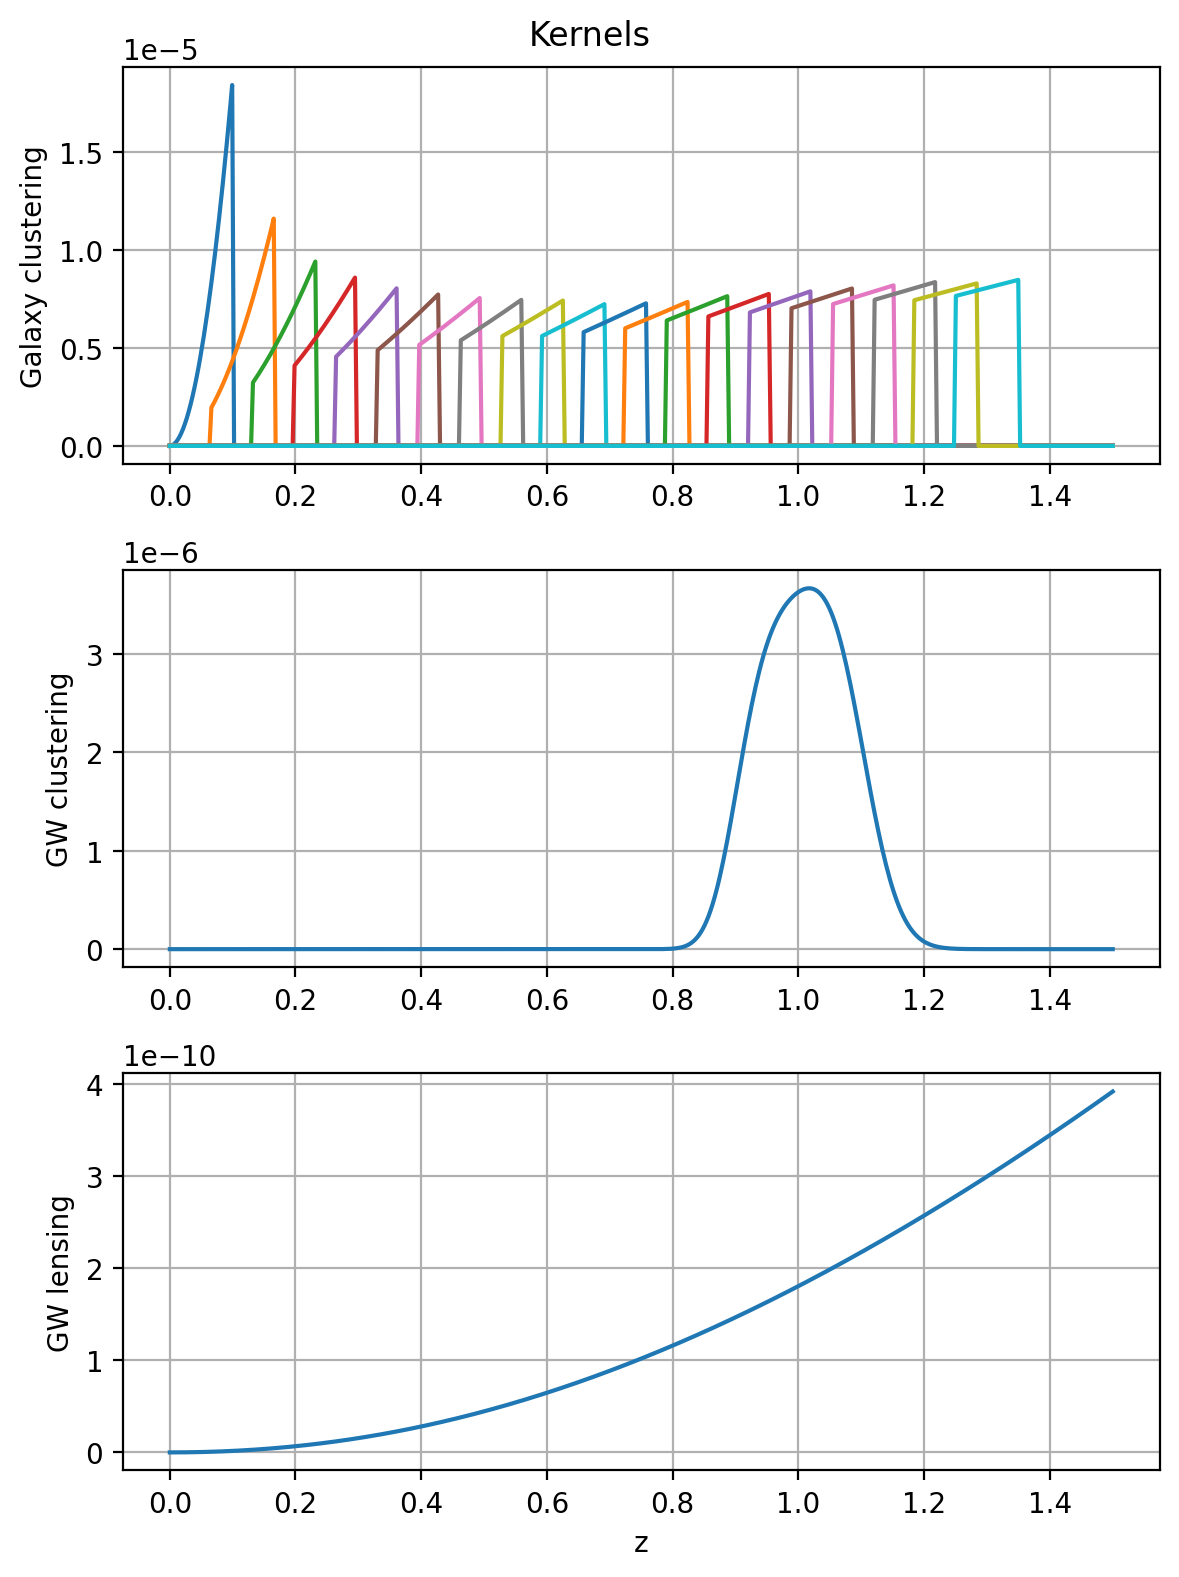

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
for i, zbin in enumerate(g_bins):
    kernel = g_tracer.compute_kernel_functions(zbin, z, cosmology)
    ax1.plot(z, kernel[0, :], label=f'Bin {i + 1}')

gw_kernel = gw_tracer.compute_kernel_functions(gw_bin, z, cosmology)
ax2.plot(z, gw_kernel[0, :])
ax3.plot(z, gw_kernel[1, :])

ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_ylabel('Galaxy clustering')
ax2.set_ylabel('GW clustering')
ax3.set_ylabel('GW lensing')
#ax1.legend()
ax3.set_xlabel('z')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Kernels')
plt.show()

Computing power spectra:

In [11]:
cp = Power(cosmology)
l = 100
galbin = 10
cls = np.empty((nbins, g_tracer.nkernels, gw_tracer.nkernels))
for i, g_bin in enumerate(g_bins):
    cls[i, :, :]= cp.cls(l, g_bin, gw_bin, g_tracer, gw_tracer, z)

Plotting results:

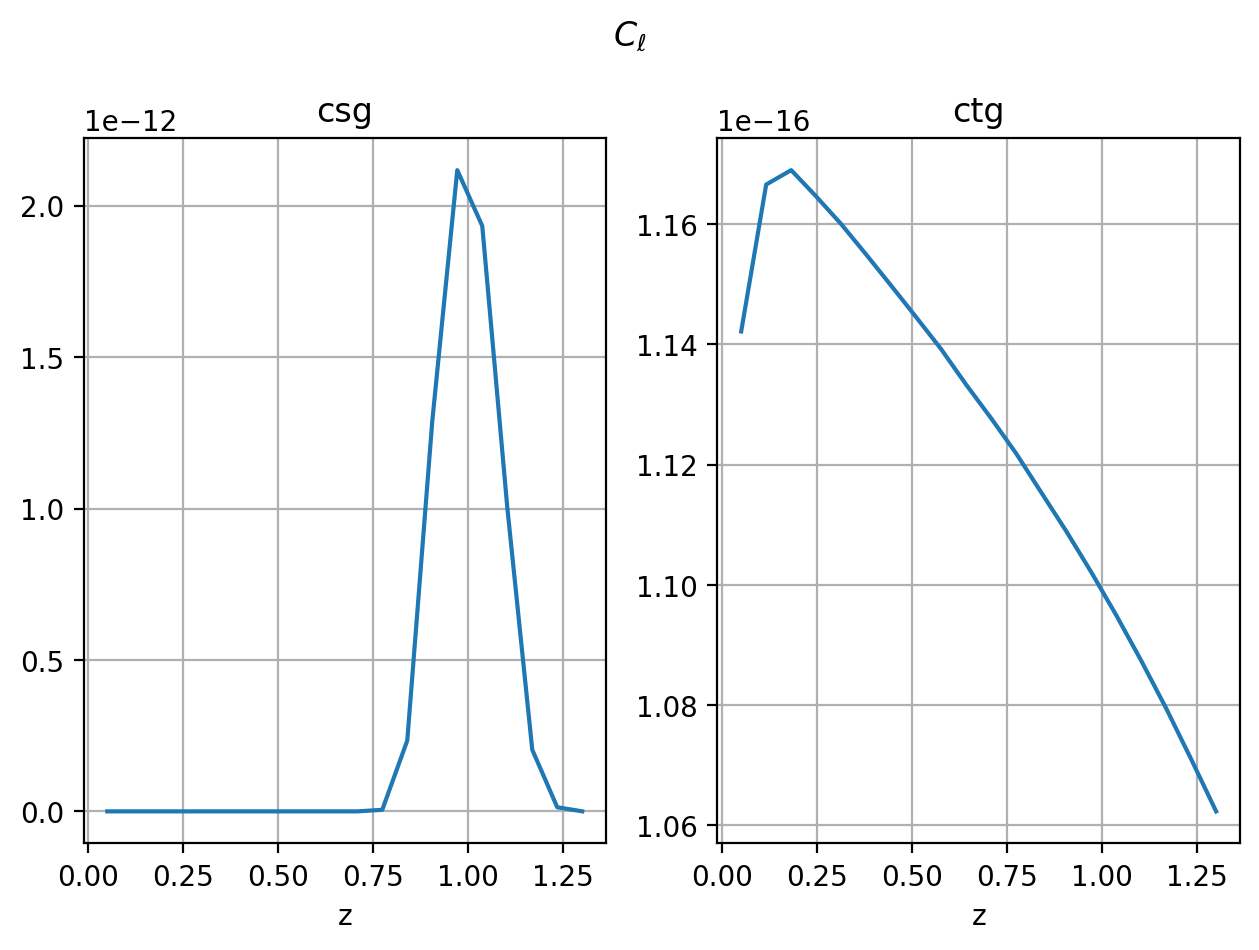

In [13]:
fig, axs = plt.subplots(g_tracer.nkernels, gw_tracer.nkernels, squeeze=False)
binvec = np.arange(nbins)
labels = [
    [f'c{k2.symbol}{k1.symbol}' for k2 in gw_tracer.kernels]
    for k1 in g_tracer.kernels
]
for i in range(g_tracer.nkernels):
    for j in range(gw_tracer.nkernels):
        axs[i][j].plot(zg_arr, cls[:, i, j])
        axs[i][j].set_xlabel('z')
        axs[i][j].set_title(labels[i][j])
        axs[i][j].grid()

fig.subplots_adjust(top=0.95)
fig.suptitle(r'$C_\ell$')
fig.tight_layout()
plt.show()